# BASELINE - CBoW

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import torch
import torchtext
import torchdata
import portalocker

### Data Pre-processing

In [45]:
# load data
data = pd.read_csv("./data/train.csv")

# check length of raw text 
data['length'] = data["comment_text"].apply(lambda x: len(x))
data['word_count'] = data["comment_text"].apply(lambda x: len(x.split(" ")))

In [46]:
avg_wc = round(data['word_count'].mean())
pct_over60 = round(sum(data['word_count'] > 60)/len(data), 2)
pct_over100 = round(sum(data['word_count'] > 100)/len(data), 2)
pct_over200 = round(sum(data['word_count'] > 200)/len(data), 2)

print("The training dataset contains {} online comments.".format(len(data)))
print("The average length of the raw text is {} (measured by characters)".format(avg_wc))
print("The proportion of comments that has over 60 words: {}".format(pct_over60))
print("The proportion of comments that has over 100 words: {}".format(pct_over100))
print("The proportion of comments that has over 200 words: {}".format(pct_over200))

The training dataset contains 159571 online comments.
The average length of the raw text is 68 (measured by characters)
The proportion of comments that has over 60 words: 0.32
The proportion of comments that has over 100 words: 0.18
The proportion of comments that has over 200 words: 0.06


Check character count distribution

<Axes: ylabel='Frequency'>

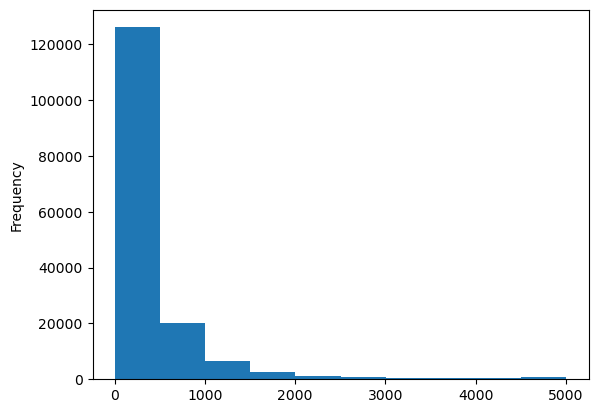

In [47]:
data['length'].plot.hist()

Check word count distribution for comments with no more than 200 words

<Axes: ylabel='Frequency'>

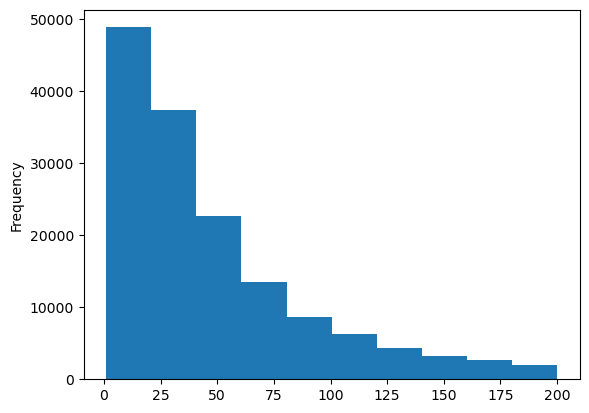

In [48]:
data['word_count'][data['word_count'] <= 200].plot.hist()

## ATTEMPT 1: Build Vocab from Text

In [57]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        '''
        data: Pandas dataframe
        split: 
        '''
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data.iloc[index]
        # Extract the relevant columns from the CSV file
        text = sample["comment_text"]
        label = sample["toxic"]
        # Apply any transformations to the data
        if self.transform:
            text, label = self.transform(text, label)
        return text, label


In [59]:
# split data: train 70%, validation 20%, test 10%
train_data, rest_data = train_test_split(data, test_size=0.3, random_state=1)
val_data, test_data = train_test_split(rest_data, test_size=0.33, random_state=1)

# load data into customized datasets
train_set = CustomDataset(train_data)
val_set = CustomDataset(val_data)
test_set = CustomDataset(test_data)

print("train:", len(train_set), "validation:", len(val_set), "test", len(test_set))

train: 111699 validation: 32074 test 15798


In [109]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
data_iter = CustomDataset(data)

def yield_tokens(iter):
    for text, _ in iter:
        yield tokenizer(text)

# build vocab from training set
vocab = build_vocab_from_iterator(
    yield_tokens(data_iter), specials=["<unk>"], min_freq=100)

dft_idx = vocab['<unk>']
vocab.set_default_index(dft_idx)

print(len(vocab), "tokens have been collected.")

6246 tokens have been collected.


In [110]:

def collate_into_bow(batch):
    '''
    Create bag of words for a batch of comments
    Input: batch 
    Output: y: labels (0, 1)
            x: features (reletive frequency)
    '''

    k = len(batch)
    m = len(vocab)
    y = torch.zeros(k)
    x = torch.zeros(k, m)

    for i, (text, label) in enumerate(batch):

        # convert tokens into numeric features
        features = [vocab[tk] for tk in tokenizer(text)]

        # get relevant frequencies for each token
        freqs = torch.zeros(m)
        for idx in features:
            if idx != 0:
                freqs[idx] += 1
        freqs = freqs / freqs.sum()
        
        y[i] = label
        y = y.type(torch.LongTensor)
        x[i] = freqs

    return x, y

In [112]:
# create DataLoader objects 
BATCH_SIZE = 16

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_into_bow)

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_into_bow)

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_into_bow)


### Single Layer BoW Model


In [113]:
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

class BoWClassifier(nn.Module):

    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
    
    def forward(self, bow_vec):
        # print(self.linear(bow_vec))
        return F.log_softmax(self.linear(bow_vec), dim=1)

In [71]:
# for idx, (text, label) in enumerate(dataloader):
#     print(text)
#     print(label)
#     if idx == 0:
#         break

The following creates a model object of the class BoWClassifier.




In [122]:
import time
import torch.optim as optim

num_labels = 2
vocab_size = len(vocab)
model = BoWClassifier(num_labels, vocab_size)

optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [123]:

loss_function = torch.nn.NLLLoss()

def evaluate(model, data_loader):
    '''
    Evaluate the model on the given data.
    '''

    model.eval()
    it = iter(data_loader)
    total_count = 0. 
    total_loss = 0.
    with torch.no_grad():

        for i, batch in enumerate(it):

            text, label = batch
            output = model(text)
            loss = loss_function(output, label)
            total_count += np.multiply(*text.size())
            total_loss += loss.item()*np.multiply(*text.size())
                
    loss = total_loss / total_count
    model.train()
    return loss

In [94]:

def train_an_epoch(train_load, validation_load, optimizer, use_cuda=False):
    '''
    '''

    model.train() # Sets the module in training mode.
    num_nan_batch = 0
    log_interval = 500
    val_losses = []
    best_model = None
    # num_nan_batch = 0

    for idx, (text, label) in enumerate(train_load):
        if use_cuda:
            text, target = text.cuda(), target.cuda()
        model.zero_grad()
        log_probs = model(text)

        # skip unidentified sentences
        has_nan = torch.isnan(log_probs).any().item()
        if has_nan:
            num_nan_batch += 1
            continue

        loss = loss_function(log_probs, label)
        # print("loss: ", loss)
        loss.backward()
        optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the training loss is {float(loss):.3f}.')
            
        if idx % (log_interval * 2) == 0 and idx > 0:
            val_loss = evaluate(model, validation_load)
            val_losses.append(val_loss)

            if val_losses:
                if val_loss < min(val_losses):
                    best_model = model
            else:
                best_model = model
    
    return best_model, val_losses, num_nan_batch



In [124]:
model.train() # Sets the module in training mode.
num_nan_batch = 0
log_interval = 500
val_losses = []
best_model = None
# num_nan_batch = 0

for idx, (text, label) in enumerate(train_loader):
    model.zero_grad()
    log_probs = model(text)

    # skip unidentified sentences
    has_nan = torch.isnan(log_probs).any().item()
    if has_nan:
        num_nan_batch += 1
        continue

    loss = loss_function(log_probs, label)
    # print("loss: ", loss)
    loss.backward()
    optimizer.step()

    if idx % log_interval == 0 and idx > 0:
        print(f'At iteration {idx} the training loss is {float(loss):.3f}.')
        
    if idx % (log_interval * 2) == 0 and idx > 0:
        val_loss = evaluate(model, val_loader)
        val_losses.append(val_loss)

        if val_losses:
            if val_loss < min(val_losses):
                best_model = model
        else:
            best_model = model


At iteration 500 the training loss is 0.680.
At iteration 1000 the training loss is 0.654.
At iteration 1500 the training loss is 0.651.
At iteration 2000 the training loss is 0.628.
At iteration 2500 the training loss is 0.638.
At iteration 3000 the training loss is 0.600.
At iteration 3500 the training loss is 0.604.
At iteration 4000 the training loss is 0.594.
At iteration 4500 the training loss is 0.625.
At iteration 5000 the training loss is 0.551.
At iteration 5500 the training loss is 0.565.
At iteration 6000 the training loss is 0.531.
At iteration 6500 the training loss is 0.548.


In [129]:
val_losses

[nan, nan, nan, nan, nan, nan]

Not enough word is catched. When there is no word identified from a text, the loss will be nan and break the evaluation process.

# ATTEMPT 2: Switch to Pre-trained Embedding GloVe

In [130]:
from itertools import combinations
from torchtext.vocab import GloVe

# It is best to save GloVe data in a cache to reuse across projects.
VECTOR_CACHE_DIR = './Desktop/glove/.vector_cache'

glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)

words = ["hello", "hi", "king", "president"]
vecs = glove.get_vecs_by_tokens(words)

print(vecs.shape)
print()
for (i, j) in combinations(range(4), 2):
    print(words[i], words[j], vecs[i].dot(vecs[j]))
print()
print(vecs)

./Desktop/glove/.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                               
100%|█████████▉| 399999/400000 [00:56<00:00, 7090.96it/s]


torch.Size([4, 300])

hello hi tensor(13.7214)
hello king tensor(2.2427)
hello president tensor(2.7678)
hi king tensor(1.4366)
hi president tensor(-2.7832)
king president tensor(14.2624)

tensor([[-0.3371, -0.2169, -0.0066,  ...,  0.4056,  0.1807,  0.6425],
        [ 0.4084, -0.1843, -0.1757,  ..., -0.5265,  0.8163,  0.7427],
        [ 0.0034, -0.3461,  0.2814,  ...,  0.0821, -0.6880,  0.3027],
        [ 0.4367,  0.1879, -0.1702,  ...,  0.0329, -0.5214,  0.2229]])


In [174]:
def collate_into_cbow(batch):
    
    k = len(batch)
    m = 300
    y = torch.zeros(k)
    x = torch.zeros(k, m)

    for i, (text, label) in enumerate(batch):
        tokens = tokenizer(text)
        features = glove.get_vecs_by_tokens(tokens)
        y[i] = label
        # x[i] = features.mean(dim=0)
        x[i] = features

    y = y.type(torch.LongTensor)

    return x, y


In [175]:
# create DataLoader objects 
BATCH_SIZE = 16

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_into_bow)

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_into_bow)

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_into_bow)


In [176]:
num_labels = 2
vocab_size = len(vocab)
model = BoWClassifier(num_labels, vocab_size)

optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [177]:
model.train() # Sets the module in training mode.
num_nan_batch = 0
log_interval = 500
val_losses = []
best_model = None
USE_GPU = False
# num_nan_batch = 0

for idx, (text, label) in enumerate(train_loader):
    model.zero_grad()
    log_probs = model(text)

    # skip unidentified sentences
    has_nan = torch.isnan(log_probs).any().item()
    if has_nan:
        num_nan_batch += 1
        continue

    loss = loss_function(log_probs, label)
    # print("loss: ", loss)
    loss.backward()
    optimizer.step()

    if idx % log_interval == 0 and idx > 0:
        print(f'At iteration {idx} the training loss is {float(loss):.3f}.')
        
    if idx % (log_interval * 2) == 0 and idx > 0:
        val_loss = evaluate(model, val_loader)
        val_losses.append(val_loss)

        if val_losses:
            if val_loss < min(val_losses):
                best_model = model
        else:
            best_model = model


At iteration 500 the training loss is 0.684.
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/yifuhou/anaconda3/envs/capp30255/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/13/_vv4l8hs25j7w31755973xv00000gn/T/ipykernel_72379/1221267523.py", line 9, in <module>
    for idx, (text, label) in enumerate(train_loader):
  File "/Users/yifuhou/anaconda3/envs/capp30255/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 634, in __next__
    data = self._next_data()
  File "/Users/yifuhou/anaconda3/envs/capp30255/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 678, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/Users/yifuhou/anaconda3/envs/capp30255/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/var/folders/13/_vv4l8hs25j7w31755973xv00000gn/T/ipykernel_72379/35725819

In [182]:
model

BoWClassifier(
  (linear): Linear(in_features=6246, out_features=2, bias=True)
)

In [181]:
for idx, (text, label) in enumerate(train_loader):
    print(text.shape)
    print(label.shape)
    if idx == 2:
        break

torch.Size([16, 6246])
torch.Size([16])
torch.Size([16, 6246])
torch.Size([16])
torch.Size([16, 6246])
torch.Size([16])


In [164]:
loss_function = torch.nn.NLLLoss()

def evaluate(model, data_loader):
    '''
    Evaluate the model on the given data.
    '''

    model.eval()
    it = iter(data_loader)
    total_count = 0. 
    total_loss = 0.
    num_nan_batch = 0

    with torch.no_grad():

        for i, batch in enumerate(it):

            text, label = batch
            output = model(text)
            
            # for text with 0 identified word, 
            # set every word frequency to 0 by default 
            if torch.isnan(output).any().item():
                output = torch.nan_to_num(output, nan=0.0)
                num_nan_batch += 1

            loss = loss_function(output, label)
            total_count += np.multiply(*text.size())
            total_loss += loss.item()*np.multiply(*text.size())

                
    loss = total_loss / total_count
    model.train()

    return loss

In [171]:
def train_an_epoch(train_load, optimizer, use_cuda=False):
    '''
    Train the model for one epoch
    '''

    model.train() # Sets the module in training mode.
    num_nan_batch = 0
    log_interval = 500

    for idx, (text, label) in enumerate(train_load):
        if use_cuda:
            text, label = text.cuda(), label.cuda()
        model.zero_grad()
        log_probs = model(text)

        # skip unidentified sentences
        has_nan = torch.isnan(log_probs).any().item()
        if has_nan:
            num_nan_batch += 1
            continue

        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()

        # if idx % log_interval == 0 and idx > 0:
        #     print(f'At iteration {idx} the training loss is {float(loss):.3f}.')
            


In [192]:
OPT_EPOCHS = 8
val_losses = []
model = BoWClassifier(2, len(vocab))

optimizer = optim.SGD(model.parameters(), lr=0.0001)

for epoch in range(1, OPT_EPOCHS + 1):
    print("----- epoch{} -----".format(epoch))
    train_an_epoch(train_loader, optimizer)
    acc = evaluate(model, val_loader)
    val_losses.append(acc)

----- epoch1 -----
----- epoch2 -----
----- epoch3 -----
----- epoch4 -----
----- epoch5 -----
----- epoch6 -----
----- epoch7 -----
----- epoch8 -----


In [194]:
get_accuracy(test_loader, False)

tensor(0.9027)

next step: run multiple epochs and check validate loss after each, implement GPU 

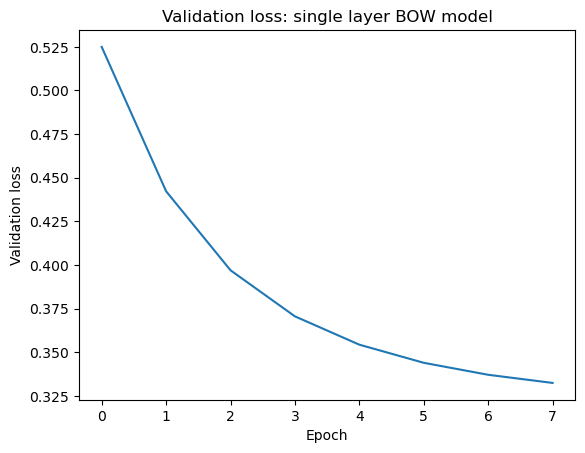

In [169]:
import matplotlib.pyplot as plt

val_losses_8ep = val_losses

x = range(len(val_losses_8ep))
plt.plot(x, val_losses_8ep)
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss: single layer BOW model')

plt.show()


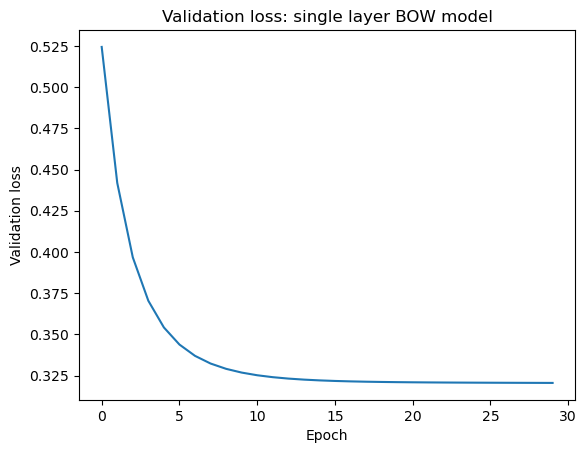

In [172]:
OPT_EPOCHS = 30
val_losses_30ep = []
model = BoWClassifier(2, len(vocab))

optimizer = optim.SGD(model.parameters(), lr=0.0001)

for epoch in range(1, OPT_EPOCHS + 1):
    # print("----- epoch{} -----".format(epoch))
    train_an_epoch(train_loader, optimizer)
    acc = evaluate(model, val_loader)
    val_losses_30ep.append(acc)

x = range(len(val_losses_30ep))
plt.plot(x, val_losses_30ep)
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss: single layer BOW model')

plt.show()


In [183]:
model

BoWClassifier(
  (linear): Linear(in_features=6246, out_features=2, bias=True)
)

In [ ]:
loss_function = torch.nn.NLLLoss()

def get_performance(model, data_loader, use_cuda=False):
    '''
    Evaluate the model on the given data.
    '''

    model.eval()
    it = iter(data_loader)
    total_count = 0. 
    total_loss = 0.

    with torch.no_grad():

        for i, batch in enumerate(it):

            text, label = batch
            if use_cuda:
                text, label = text.cuda(), label.cuda()
            output = model(text)
            
            # for text with 0 identified word, 
            # set every word frequency to 0 by default 
            if torch.isnan(output).any().item():
                output = torch.nan_to_num(output, nan=0.0)
                # num_nan_batch += 1

            loss = loss_function(output, label)
            total_count += np.multiply(*text.size())
            total_loss += loss.item()*np.multiply(*text.size())

                
    loss = total_loss / total_count
    model.train()
    print("evaluate: validation loss:", loss)

    return loss

In [186]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_accuracy(dataloader, use_cuda):
    '''
    '''
    model.eval()
    with torch.no_grad():

        total_count = 0
        total_correct = 0
        
        for idx, (text, label) in enumerate(dataloader):
            if use_cuda:
                text = text.cuda()
                label = label.cuda()

            total_count += len(label)
            log_probs = model(text)
            if torch.isnan(log_probs).any().item():
                log_probs = torch.nan_to_num(log_probs, nan=0.0)
                
            preds = torch.argmax(log_probs, dim=1)
            total_correct += sum(preds == label)

            # Calculate the performance metrics
            accuracy = accuracy_score(label, preds)
            precision = precision_score(label, preds)
            recall = recall_score(label, preds)
            f1 = f1_score(label, preds)

            

        return 

In [191]:
len(test_loader)

988

In [187]:
get_accuracy(test_loader, False)

tensor(0.9027)

In [189]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the predictions and labels as numpy arrays
predictions = np.array([1, 1, 1, 0, 1])
labels = np.array([1, 1, 0, 0, 1])

# Calculate the performance metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8
Precision: 0.75
Recall: 1.0
F1 Score: 0.8571428571428571
